# FCA

Technical Challenge for Data Science Candidates

This workbook loads a pickle file from the prior notebook.

Visualisation

In [69]:
import numpy as np
import pandas as pd
import math
import json

from os import path

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns

pd.__version__

'0.24.2'

In [70]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [71]:
# this is the local Utility module and it reloaded each time.
from fca import Utility

In [72]:
%load_ext autoreload
%autoreload 1
%aimport fca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# My utility singleton.
i0 = Utility.instance()

## Visualisations

There is a lot of data, take a sample.

In [135]:
df2 = pd.read_pickle("catted.pickle")
df2 = pd.read_pickle("scaled.pickle")
df2 = pd.read_pickle("coded.pickle")

y = df2.y

In [136]:
## Remove the columns with 0 for correlations
cols = list(X.columns)
cols1 = list(filter(lambda x: x.endswith('0'), cols))
cols2 = set(cols).difference(cols1)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [138]:
# Default case is take a small sample

X = X_test[cols2]
y = y_test

In [104]:
# Another variant is to check when the outcome is true (or false)
# This can trap conditioned outcomes
set(df2.y)
X = df2[df2.y > 0][cols2]
y = df2.y

{-0.3563093198329269, 2.8065502200978045}

In [139]:
X.head()
X.info()

,previous,contact,euribor3m,age,marital,day_of_week,nr.employed,pdays,default,emp.var.rate,...,y,poutcome,job,cons.conf.idx,education,housing,month,cons.price.idx,duration,loan
3318,0,1,4.860,31,3,2,5191.0,40,1,1.1,...,0,0,11,-36.4,5,2,6,93.994,168,1
307,0,1,4.857,57,2,1,5191.0,40,1,1.1,...,0,0,2,-36.4,2,2,6,93.994,205,2
12715,0,0,4.960,25,1,1,5228.1,40,0,1.4,...,0,0,7,-42.7,5,1,3,93.918,252,1
12703,0,0,4.960,41,3,1,5228.1,40,0,1.4,...,0,0,4,-42.7,0,2,3,93.918,285,1
7405,0,1,4.864,26,3,0,5191.0,40,1,1.1,...,0,0,6,-36.4,3,2,6,93.994,138,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8238 entries, 3318 to 19834
Data columns (total 21 columns):
previous          8238 non-null int64
contact           8238 non-null int8
euribor3m         8238 non-null float64
age               8238 non-null int64
marital           8238 non-null int8
day_of_week       8238 non-null int8
nr.employed       8238 non-null float64
pdays             8238 non-null int64
default           8238 non-null int8
emp.var.rate      8238 non-null float64
campaign          8238 non-null int64
y                 8238 non-null int8
poutcome          8238 non-null int8
job               8238 non-null int8
cons.conf.idx     8238 non-null float64
education         8238 non-null int8
housing           8238 non-null int8
month             8238 non-null int8
cons.price.idx    8238 non-null float64
duration          8238 non-null int64
loan              8238 non-null int8
dtypes: float64(5), int64(5), int8(11)
memory usage: 796.4 KB


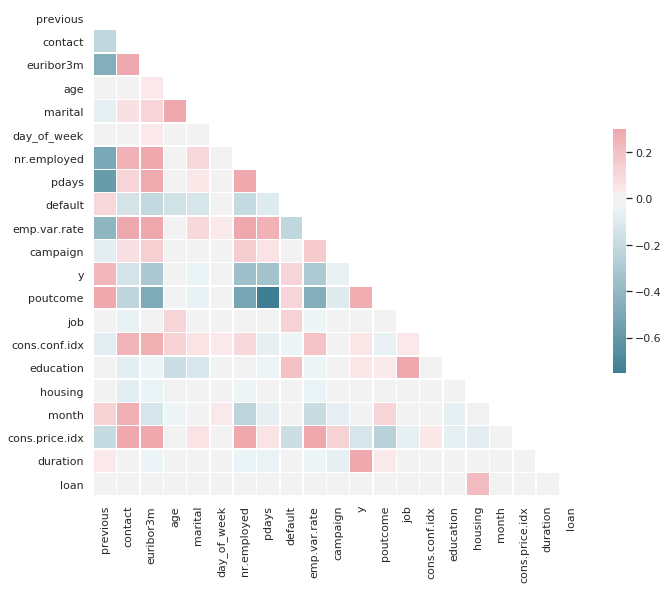

In [140]:
## Correlations

sns.set(style="white")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

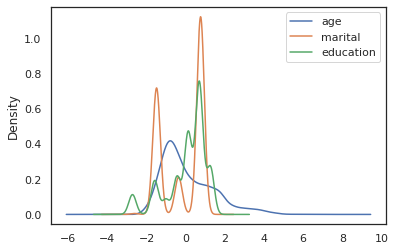

In [110]:
# Check the age shape

X[['age', 'marital', 'education']].plot.density()

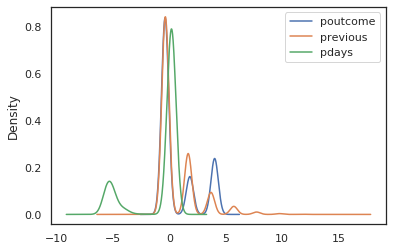

In [108]:
# These seem to lagged identical
X[['poutcome', 'previous', 'pdays']].plot.density()

### euribor3m cluster

These seem to be related.

Looking at these. It might be the future-value of the loan at the time the loanee applied. 
The most information would then be in the price

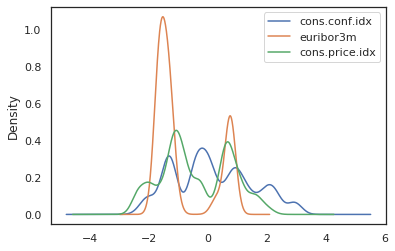

In [111]:
X[['cons.conf.idx', 'euribor3m', 'cons.price.idx']].plot.density()

In [ ]:
# A very time-consuming pair plot even on the sample

sns.pairplot(X)

In [31]:
df2['marital'];

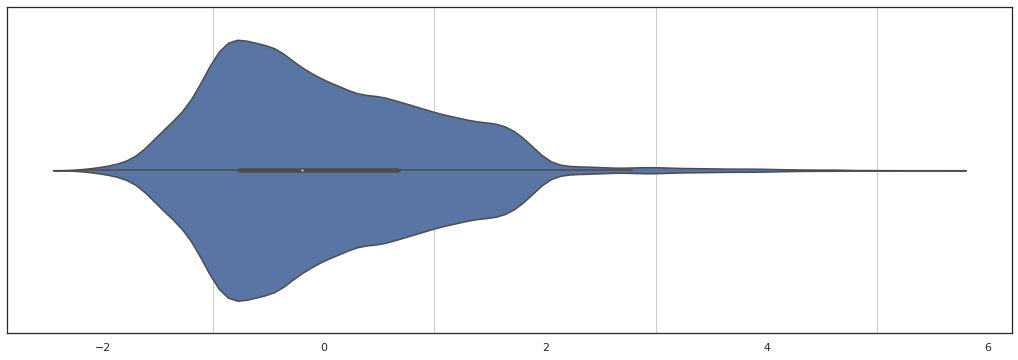

In [113]:
# Some violin plots

from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot(x=['age'], data=df2)

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

ax1.grid(which='minor', axis='x', linewidth=1)

In [53]:
math.floor(math.log(X.shape[1], 2))

4

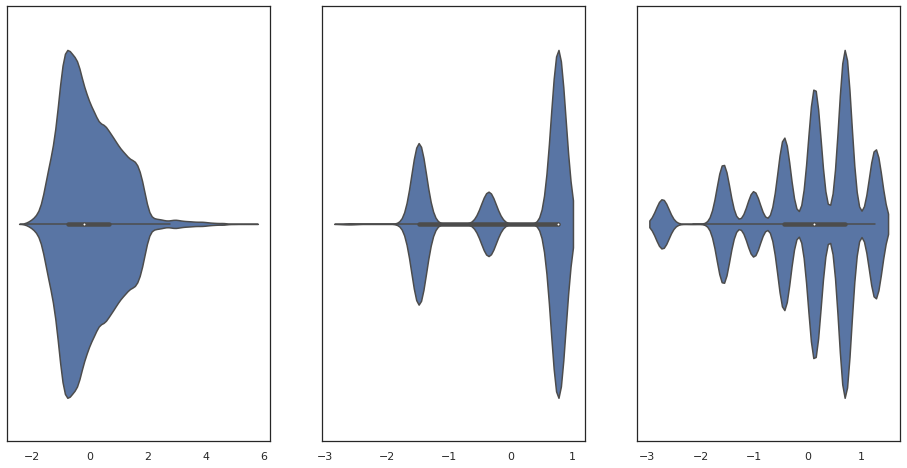

In [126]:
fig, axs = plt.subplots(figsize=(16,8), ncols=3)

sns.violinplot(x=['age'], data=df2, ax=axs[0])
sns.violinplot(x=['marital'], data=df2, ax=axs[1])
sns.violinplot(x=['education'], data=df2, ax=axs[2])